<a href="https://colab.research.google.com/github/ChoiDae1/2022_KCCV_Programming/blob/main/Few%20Shot%20Segmentation/CATs_Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Welcome to Cost Aggregation Transformer (CATs) Demo

[[Project Page](https://sunghwanhong.github.io/CATs/)] [[arXiv](https://arxiv.org/abs/2106.02520#:~:text=CATs%3A%20Cost%20Aggregation%20Transformers%20for%20Visual%20Correspondence,-Seokju%20Cho%2C%20Sunghwan&text=We%20propose%20a%20novel%20cost,class%20appearance%20and%20geometric%20variations.)]

![Qualitative](https://sunghwanhong.github.io/CATs/qualitative.png)

Before executing the codes, please make sure to follow the [Link](https://drive.google.com/drive/folders/1xrplc4qT8Js3MPy40OVGCBaH_cZ2AwSk?usp=sharing) and add shortcut to your drive
![](https://github.com/Seokju-Cho/CATs-Demo/blob/main/drive.png?raw=true)


In [ ]:
!pip install timm

     |████████████████████████████████| 431 kB 8.1 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = 'drive/MyDrive/cats_demo/'

Mounted at /content/drive


In [ ]:
import os.path as osp
import os
import sys
from operator import add
from functools import reduce, partial

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import timm
from timm.models.layers import DropPath, trunc_normal_
from torchvision.models import resnet

from PIL import Image
from torchvision import transforms

In [ ]:



class FeatureL2Norm(nn.Module):
    """
    Implementation by Ignacio Rocco
    paper: https://arxiv.org/abs/1703.05593
    project: https://github.com/ignacio-rocco/cnngeometric_pytorch
    """
    def __init__(self):
        super(FeatureL2Norm, self).__init__()

    def forward(self, feature, dim=1):
        epsilon = 1e-6
        norm = torch.pow(torch.sum(torch.pow(feature, 2), dim) + epsilon, 0.5).unsqueeze(dim).expand_as(feature)
        return torch.div(feature, norm)


def unnormalise_and_convert_mapping_to_flow(map):
    # here map is normalised to -1;1
    # we put it back to 0,W-1, then convert it to flow
    B, C, H, W = map.size()
    mapping = torch.zeros_like(map)
    # mesh grid
    mapping[:,0,:,:] = (map[:, 0, :, :].float().clone() + 1) * (W - 1) / 2.0 # unormalise
    mapping[:,1,:,:] = (map[:, 1, :, :].float().clone() + 1) * (H - 1) / 2.0 # unormalise

    xx = torch.arange(0, W).view(1,-1).repeat(H,1)
    yy = torch.arange(0, H).view(-1,1).repeat(1,W)
    xx = xx.view(1,1,H,W).repeat(B,1,1,1)
    yy = yy.view(1,1,H,W).repeat(B,1,1,1)
    grid = torch.cat((xx,yy),1).float()

    if mapping.is_cuda:
        grid = grid.cuda()
    flow = mapping - grid
    return flow


r'''
Modified timm library Vision Transformer implementation
https://github.com/rwightman/pytorch-image-models
'''
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x
        
class Attention(nn.Module):
    def __init__(self, dim, num_heads=8, qkv_bias=False, qk_scale=None, attn_drop=0., proj_drop=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        # NOTE scale factor was wrong in my original version, can set manually to be compat with prev weights
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x):
        B, N, C = x.shape
        # B N (3 * C)
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]   # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class MultiscaleBlock(nn.Module):

    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.attn = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        self.attn_multiscale = Attention(
            dim, num_heads=num_heads, qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)
        # NOTE: drop path for stochastic depth, we shall see if this is better than dropout here
        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm1 = norm_layer(dim)
        self.norm2 = norm_layer(dim)
        self.norm3 = norm_layer(dim)
        self.norm4 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)
        self.mlp2 = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

    def forward(self, x):
        '''
        Multi-level aggregation
        '''
        B, N, H, W = x.shape
        if N == 1:
            x = x.flatten(0, 1)
            x = x + self.drop_path(self.attn(self.norm1(x)))
            x = x + self.drop_path(self.mlp(self.norm2(x)))
            return x.view(B, N, H, W)
        x = x.flatten(0, 1) # B Level (S T)
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp2(self.norm4(x)))
        x = x.view(B, N, H, W).transpose(1, 2).flatten(0, 1) 
        x = x + self.drop_path(self.attn_multiscale(self.norm3(x)))
        x = x.view(B, H, N, W).transpose(1, 2).flatten(0, 1)
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        x = x.view(B, N, H, W)
        return x


class TransformerAggregator(nn.Module):
    def __init__(self, num_hyperpixel, img_size=224, embed_dim=768, depth=12, num_heads=12, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0., norm_layer=None):
        super().__init__()
        self.img_size = img_size
        self.num_features = self.embed_dim = embed_dim  # num_features for consistency with other models
        norm_layer = norm_layer or partial(nn.LayerNorm, eps=1e-6)

        self.pos_embed_x = nn.Parameter(torch.zeros(1, num_hyperpixel, 1, img_size, embed_dim // 2))
        self.pos_embed_y = nn.Parameter(torch.zeros(1, num_hyperpixel, img_size, 1, embed_dim // 2))
        self.pos_drop = nn.Dropout(p=drop_rate)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]  # stochastic depth decay rule
        self.blocks = nn.Sequential(*[
            MultiscaleBlock(
                dim=embed_dim, num_heads=num_heads, mlp_ratio=mlp_ratio, qkv_bias=qkv_bias, qk_scale=qk_scale,
                drop=drop_rate, attn_drop=attn_drop_rate, drop_path=dpr[i], norm_layer=norm_layer)
            for i in range(depth)])
        self.proj = nn.Linear(embed_dim, img_size ** 2)
        self.norm = norm_layer(embed_dim)

        trunc_normal_(self.pos_embed_x, std=.02)
        trunc_normal_(self.pos_embed_y, std=.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, corr, source, target):
        B = corr.shape[0]
        x = corr.clone()
        
        pos_embed = torch.cat((self.pos_embed_x.repeat(1, 1, self.img_size, 1, 1), self.pos_embed_y.repeat(1, 1, 1, self.img_size, 1)), dim=4)
        pos_embed = pos_embed.flatten(2, 3)

        x = torch.cat((x.transpose(-1, -2), target), dim=3) + pos_embed
        x = self.proj(self.blocks(x)).transpose(-1, -2) + corr  # swapping the axis for swapping self-attention. # s->t

        x = torch.cat((x, source), dim=3) + pos_embed
        x = self.proj(self.blocks(x)) + corr # t->s 

        return x.mean(1)


class FeatureExtractionHyperPixel(nn.Module):
    def __init__(self, hyperpixel_ids, feature_size, freeze=True):
        super().__init__()
        self.backbone = resnet.resnet101(pretrained=True)
        self.feature_size = feature_size
        if freeze:
            for param in self.backbone.parameters():
                param.requires_grad = False
        nbottlenecks = [3, 4, 23, 3]
        self.bottleneck_ids = reduce(add, list(map(lambda x: list(range(x)), nbottlenecks)))
        self.layer_ids = reduce(add, [[i + 1] * x for i, x in enumerate(nbottlenecks)])
        self.hyperpixel_ids = hyperpixel_ids
    
    
    def forward(self, img):
        r"""Extract desired a list of intermediate features"""

        feats = []

        # Layer 0
        feat = self.backbone.conv1.forward(img)
        feat = self.backbone.bn1.forward(feat)
        feat = self.backbone.relu.forward(feat)
        feat = self.backbone.maxpool.forward(feat)
        if 0 in self.hyperpixel_ids:
            feats.append(feat.clone())

        # Layer 1-4
        for hid, (bid, lid) in enumerate(zip(self.bottleneck_ids, self.layer_ids)):
            res = feat
            feat = self.backbone.__getattr__('layer%d' % lid)[bid].conv1.forward(feat)
            feat = self.backbone.__getattr__('layer%d' % lid)[bid].bn1.forward(feat)
            feat = self.backbone.__getattr__('layer%d' % lid)[bid].relu.forward(feat)
            feat = self.backbone.__getattr__('layer%d' % lid)[bid].conv2.forward(feat)
            feat = self.backbone.__getattr__('layer%d' % lid)[bid].bn2.forward(feat)
            feat = self.backbone.__getattr__('layer%d' % lid)[bid].relu.forward(feat)
            feat = self.backbone.__getattr__('layer%d' % lid)[bid].conv3.forward(feat)
            feat = self.backbone.__getattr__('layer%d' % lid)[bid].bn3.forward(feat)

            if bid == 0:
                res = self.backbone.__getattr__('layer%d' % lid)[bid].downsample.forward(res)

            feat += res

            if hid + 1 in self.hyperpixel_ids:
                feats.append(feat.clone())
                #if hid + 1 == max(self.hyperpixel_ids):
                #    break
            feat = self.backbone.__getattr__('layer%d' % lid)[bid].relu.forward(feat)

        # Up-sample & concatenate features to construct a hyperimage
        for idx, feat in enumerate(feats):
            feats[idx] = F.interpolate(feat, self.feature_size, None, 'bilinear', True)

        return feats


class CATs(nn.Module):
    def __init__(self,
    feature_size=16,
    feature_proj_dim=128,
    depth=4,
    num_heads=6,
    mlp_ratio=4,
    hyperpixel_ids=[0,8,20,21,26,28,29,30],
    freeze=True):
        super().__init__()
        self.feature_size = feature_size
        self.feature_proj_dim = feature_proj_dim
        self.decoder_embed_dim = self.feature_size ** 2 + self.feature_proj_dim
        
        channels = [64] + [256] * 3 + [512] * 4 + [1024] * 23 + [2048] * 3

        self.feature_extraction = FeatureExtractionHyperPixel(hyperpixel_ids, feature_size, freeze)
        self.proj = nn.ModuleList([
            nn.Linear(channels[i], self.feature_proj_dim) for i in hyperpixel_ids
        ])

        self.decoder = TransformerAggregator(
            img_size=self.feature_size, embed_dim=self.decoder_embed_dim, depth=depth, num_heads=num_heads,
            mlp_ratio=mlp_ratio, qkv_bias=True, norm_layer=partial(nn.LayerNorm, eps=1e-6),
            num_hyperpixel=len(hyperpixel_ids))
            
        self.l2norm = FeatureL2Norm()
    
        self.x_normal = np.linspace(-1,1,self.feature_size)
        self.x_normal = nn.Parameter(torch.tensor(self.x_normal, dtype=torch.float, requires_grad=False))
        self.y_normal = np.linspace(-1,1,self.feature_size)
        self.y_normal = nn.Parameter(torch.tensor(self.y_normal, dtype=torch.float, requires_grad=False))
        
    def softmax_with_temperature(self, x, beta, d = 1):
        r'''SFNet: Learning Object-aware Semantic Flow (Lee et al.)'''
        M, _ = x.max(dim=d, keepdim=True)
        x = x - M # subtract maximum value for stability
        exp_x = torch.exp(x/beta)
        exp_x_sum = exp_x.sum(dim=d, keepdim=True)
        return exp_x / exp_x_sum

    def soft_argmax(self, corr, beta=0.02):
        r'''SFNet: Learning Object-aware Semantic Flow (Lee et al.)'''
        b,_,h,w = corr.size()
        
        corr = self.softmax_with_temperature(corr, beta=beta, d=1)
        corr = corr.view(-1,h,w,h,w) # (target hxw) x (source hxw)

        grid_x = corr.sum(dim=1, keepdim=False) # marginalize to x-coord.
        x_normal = self.x_normal.expand(b,w)
        x_normal = x_normal.view(b,w,1,1)
        grid_x = (grid_x*x_normal).sum(dim=1, keepdim=True) # b x 1 x h x w
        
        grid_y = corr.sum(dim=2, keepdim=False) # marginalize to y-coord.
        y_normal = self.y_normal.expand(b,h)
        y_normal = y_normal.view(b,h,1,1)
        grid_y = (grid_y*y_normal).sum(dim=1, keepdim=True) # b x 1 x h x w
        return grid_x, grid_y
    
    def mutual_nn_filter(self, correlation_matrix):
        r"""Mutual nearest neighbor filtering (Rocco et al. NeurIPS'18)"""
        corr_src_max = torch.max(correlation_matrix, dim=3, keepdim=True)[0]
        corr_trg_max = torch.max(correlation_matrix, dim=2, keepdim=True)[0]
        corr_src_max[corr_src_max == 0] += 1e-30
        corr_trg_max[corr_trg_max == 0] += 1e-30

        corr_src = correlation_matrix / corr_src_max
        corr_trg = correlation_matrix / corr_trg_max

        return correlation_matrix * (corr_src * corr_trg)
    
    def corr(self, src, trg):
        return src.flatten(2).transpose(-1, -2) @ trg.flatten(2)

    def forward(self, target, source):
        B, _, H, W = target.size()

        src_feats = self.feature_extraction(source)
        tgt_feats = self.feature_extraction(target)

        corrs = []
        src_feats_proj = []
        tgt_feats_proj = []
        for i, (src, tgt) in enumerate(zip(src_feats, tgt_feats)):
            corr = self.corr(self.l2norm(src), self.l2norm(tgt))
            corrs.append(corr)
            src_feats_proj.append(self.proj[i](src.flatten(2).transpose(-1, -2)))
            tgt_feats_proj.append(self.proj[i](tgt.flatten(2).transpose(-1, -2)))

        src_feats = torch.stack(src_feats_proj, dim=1)
        tgt_feats = torch.stack(tgt_feats_proj, dim=1)
        corr = torch.stack(corrs, dim=1) # B Level S T
        
        corr = self.mutual_nn_filter(corr)

        refined_corr = self.decoder(corr, src_feats, tgt_feats)

        grid_x, grid_y = self.soft_argmax(refined_corr.view(B, -1, self.feature_size, self.feature_size))

        flow = torch.cat((grid_x, grid_y), dim=1)
        flow = unnormalise_and_convert_mapping_to_flow(flow)

        return flow

In [ ]:
device = torch.device('cuda:0')
model = CATs(
        feature_size=16, feature_proj_dim=128,
        depth=1, num_heads=6, mlp_ratio=4,
        hyperpixel_ids=[0,8,20,21,26,28,29,30], freeze=True).to(device)

checkpoint = torch.load(osp.join(f'{path}/', 'model_best.pth'))
model.load_state_dict(checkpoint['state_dict'])

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth


  0%|          | 0.00/171M [00:00<?, ?B/s]

<All keys matched successfully>

In [ ]:

class PointTPS(nn.Module):
    def __init__(self, kps_a, kps_b, relaxation):
        super(PointTPS, self).__init__()
        l2 = PointTPS.__build_l2_mat(kps_a, kps_a)

        l2[l2 == 0] = 1
        K = l2 * torch.log(l2) * (1/2.0)
        K = K + relaxation * torch.diag(torch.ones(len(kps_a)))
        P = torch.cat([torch.ones(len(kps_a), 1), kps_a], dim=1)

        L_up = torch.cat([K, P], dim=1)
        L_down = torch.cat([P.t(), torch.zeros((3, 3))], dim=1)
        L = torch.cat([L_up, L_down], dim=0)

        v = kps_b - kps_a
        v = torch.cat([v, torch.zeros(3, 2)], dim=0)
        W = L.inverse() @ v

        self.register_buffer('kps_a', kps_a)
        self.register_buffer('W', W)

    def forward(self, pts):
        l2 = PointTPS.__build_l2_mat(self.kps_a, pts)

        l2[(l2 == 0).detach()] = 1
        v = l2 * torch.log(l2) * (1/2.0)

        o = pts[:, 0] - pts[:, 0] + 1

        x = torch.stack([o, pts[:, 0], pts[:, 1]], dim=0)
        x = torch.cat([v, x], dim=0)

        z_x = x.t() @ (self.W[:, 0])
        z_y = x.t() @ (self.W[:, 1])

        target_x = pts[:, 0] + z_x
        target_y = pts[:, 1] + z_y

        return torch.stack([target_x, target_y], dim=1)

    @staticmethod
    def __build_l2_mat(pts_a, pts_b):
        n_a = len(pts_a)
        n_b = len(pts_b)

        m1 = torch.stack([pts_a] * n_b)
        m2 = torch.stack([pts_b] * n_a)

        l2 = ((m1.transpose(0, 1) - m2) ** 2).sum(2)

        return l2


class ImageTPS(PointTPS):
    def __init__(self, kps_a, kps_b, in_size, out_size, relaxation=0):
        super().__init__(kps_b, kps_a, relaxation)
        ws = torch.linspace(0, out_size[0], steps=out_size[0])
        hs = torch.linspace(0, out_size[1], steps=out_size[1])

        self.register_buffer('hs', hs)
        self.register_buffer('ws', ws)
        self.register_buffer('in_size', torch.FloatTensor([in_size]))
        self.out_size = out_size

    def forward(self, img):
        img_h = self.out_size[1]
        img_w = self.out_size[0]
        hs = torch.stack([self.hs] * img_w, dim=1).view(-1)
        ws = torch.stack([self.ws] * img_h, dim=0).view(-1)

        pts = torch.stack([ws, hs], dim=1)
        target_pts = super().forward(pts)
        target_pts = (target_pts - (self.in_size / 2)) / (self.in_size / 2)

        warped_img = F.grid_sample(img.unsqueeze(0), target_pts.view(1, img_h, img_w, 2), mode='bilinear')
        warped_img = warped_img.squeeze(0)

        return warped_img

import matplotlib.pyplot as plt
from matplotlib.patches import Arrow, Circle, ConnectionPatch

def unnormalize(image):
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    img = image.clone()
    for im_channel, mean, std in zip(img, mean, std):
        im_channel.mul_(std).add_(mean)
    return img

def plot_matching_to_file_qualitative(src_img, trg_img, src_kps, trg_kps, mask):
    mask = F.interpolate(mask[None].permute(0, 3, 1, 2), size=(256, 256), mode='bilinear', align_corners=True)
    fig, ax = plt.subplots(1, 4, figsize=(40, 40))
    fig.subplots_adjust(wspace=0)
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    ax[3].axis('off')
    ax[0].imshow(unnormalize(src_img).cpu().permute(1, 2, 0))
    ax[0].imshow(mask.squeeze(0).permute(1, 2, 0))
    ax[1].imshow(unnormalize(trg_img).cpu().permute(1, 2, 0))

    patches = [Circle((x, y), radius=5, color='limegreen') for i, (x, y) in enumerate(src_kps) if not x < 0]
    for p in patches:
        ax[0].add_patch(p)

    
    patches = [Circle((x, y), radius=5, color='limegreen') for i, (x, y) in enumerate(trg_kps) if not x < 0]
    for p in patches:
        ax[1].add_patch(p)

    
    for i, ((x_src, y_src), (x_trg, y_trg)) in enumerate(zip(src_kps, trg_kps)):
        if not x_src < 0:
            con = ConnectionPatch(xyA=(x_src, y_src),
                                    xyB=(x_trg, y_trg),
                                    coordsA='data', coordsB='data',
                                    axesA=ax[0], axesB=ax[1],
                                    color='limegreen', lw=4)
            fig.add_artist(con)

            
            
    img_tps = ImageTPS(
        src_kps.cpu(),
        trg_kps.cpu(),
        (256, 256), (256, 256), 
        2000
    )
    ax[2].imshow(unnormalize(img_tps(src_img.squeeze(0))).permute(1, 2, 0))
    ax[3].imshow(unnormalize(trg_img).cpu().permute(1, 2, 0))
    ax[3].imshow(img_tps(mask.squeeze(0)).permute(1, 2, 0))
    plt.show()
    plt.clf()


def load_image_tensor(path):
    img = Image.open(path).convert('RGB')
    transform = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
    return transform(img)[None]

def load_image_with_alpha(path):
    return torch.tensor(np.array(Image.open(path).convert('RGBA')))


def normalize(points, res, out_res):
    return points.div(out_res - 1).add(-0.5).mul(2).mul((res - 1) / res)
  
def flow2kps(trg_kps, flow, n_pts, upsample_size=(256, 256)):
    _, _, h, w = flow.size()
    flow = F.interpolate(flow, upsample_size, mode='bilinear') * (upsample_size[0] / h)
    
    src_kps = []
    for trg_kps, flow, n_pts in zip(trg_kps, flow, n_pts):
        size = trg_kps.size(1)

        kp = torch.clamp(trg_kps.narrow_copy(1, 0, n_pts), 0, upsample_size[0] - 1)
        kp_norm = normalize(kp, 256, 256)  # (N, P, 1, 2)
        estimated_kps = kp + F.grid_sample(flow.unsqueeze(0), kp_norm.permute(1, 0).unsqueeze(0).unsqueeze(2).float(), mode='bilinear').squeeze(3).squeeze(0)

        estimated_kps = torch.cat((estimated_kps, torch.ones(2, size - n_pts).cuda() * -1), dim=1)
        src_kps.append(estimated_kps)

    return torch.stack(src_kps)

def flow2kps_real(kp_dog, trg_kps, flow, n_pts, upsample_size=(256, 256)):
    kp_dog = kp_dog.to(flow.device)
    kp_dog_warped = flow2kps(kp_dog.T.unsqueeze(0).repeat(flow.size(0), 1, 1), flow, flow.size(0) * [kp_dog.size(0)], upsample_size)
    flow_est = []
    for kp in kp_dog_warped:
        img_tps = ImageTPS(
            kp.squeeze(0).T.cpu(),
            kp_dog.cpu(),
            (256, 256), (256, 256), 
            2000
        )
        flow_est.append(img_tps().to(flow.device))

    return flow2kps(trg_kps, torch.stack(flow_est), n_pts, upsample_size)

In [ ]:
src = load_image_tensor(f'{path}/podong.jpeg').to(device)
mask = load_image_with_alpha(f'{path}/podong_birthday.png')

kp_podong = torch.tensor(
        [(245, 125), (175, 235), (300, 235), (235, 300), (235, 350)]
    ).to(device) // 2

def inference(src, trg, kp, img_path):
    trg = load_image_tensor(img_path).to(device)
    estimated_flow = model(src, trg)
    estimated_keypoint = flow2kps(kp.T[None], estimated_flow, [kp.size(0)], (256, 256))

    plot_matching_to_file_qualitative(src.squeeze(0).cpu().detach(), trg.squeeze(0).cpu().detach(), 
                                      kp.cpu().detach(), estimated_keypoint.squeeze(0).T.cpu().detach(),
                                    mask.float())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1

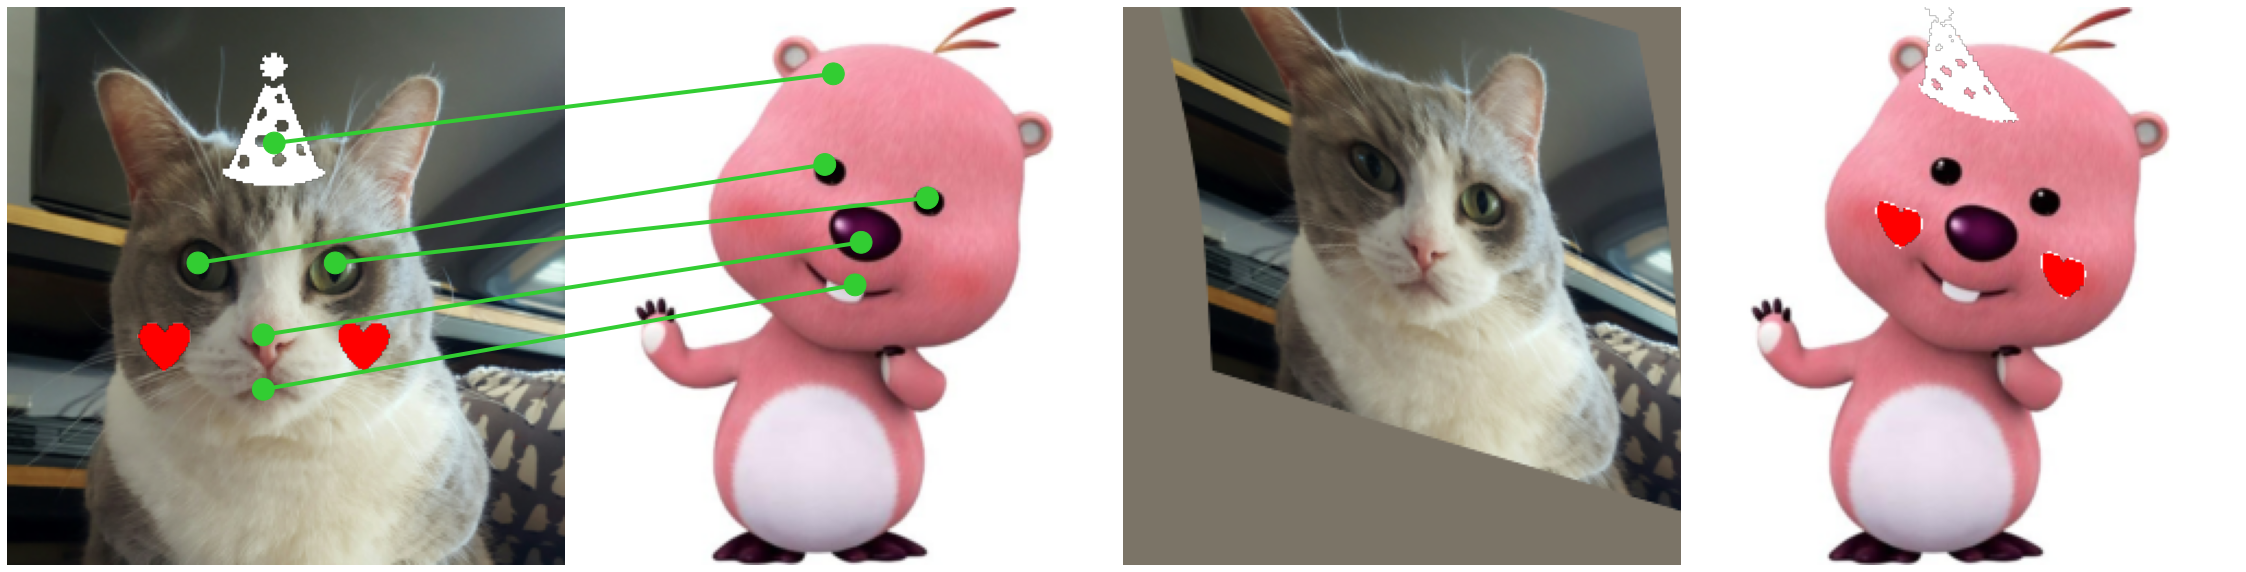

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

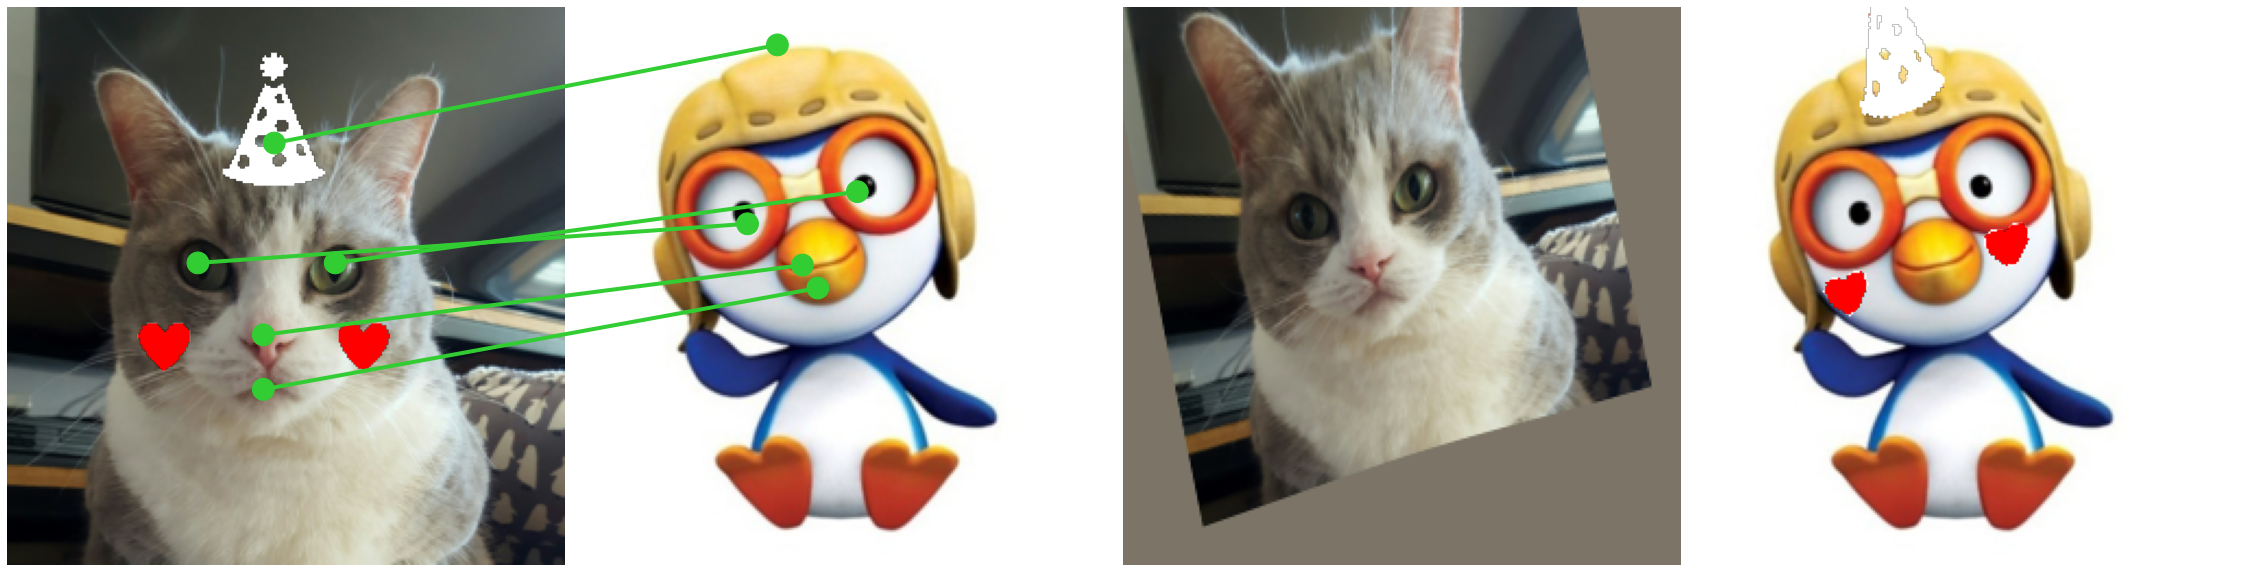

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

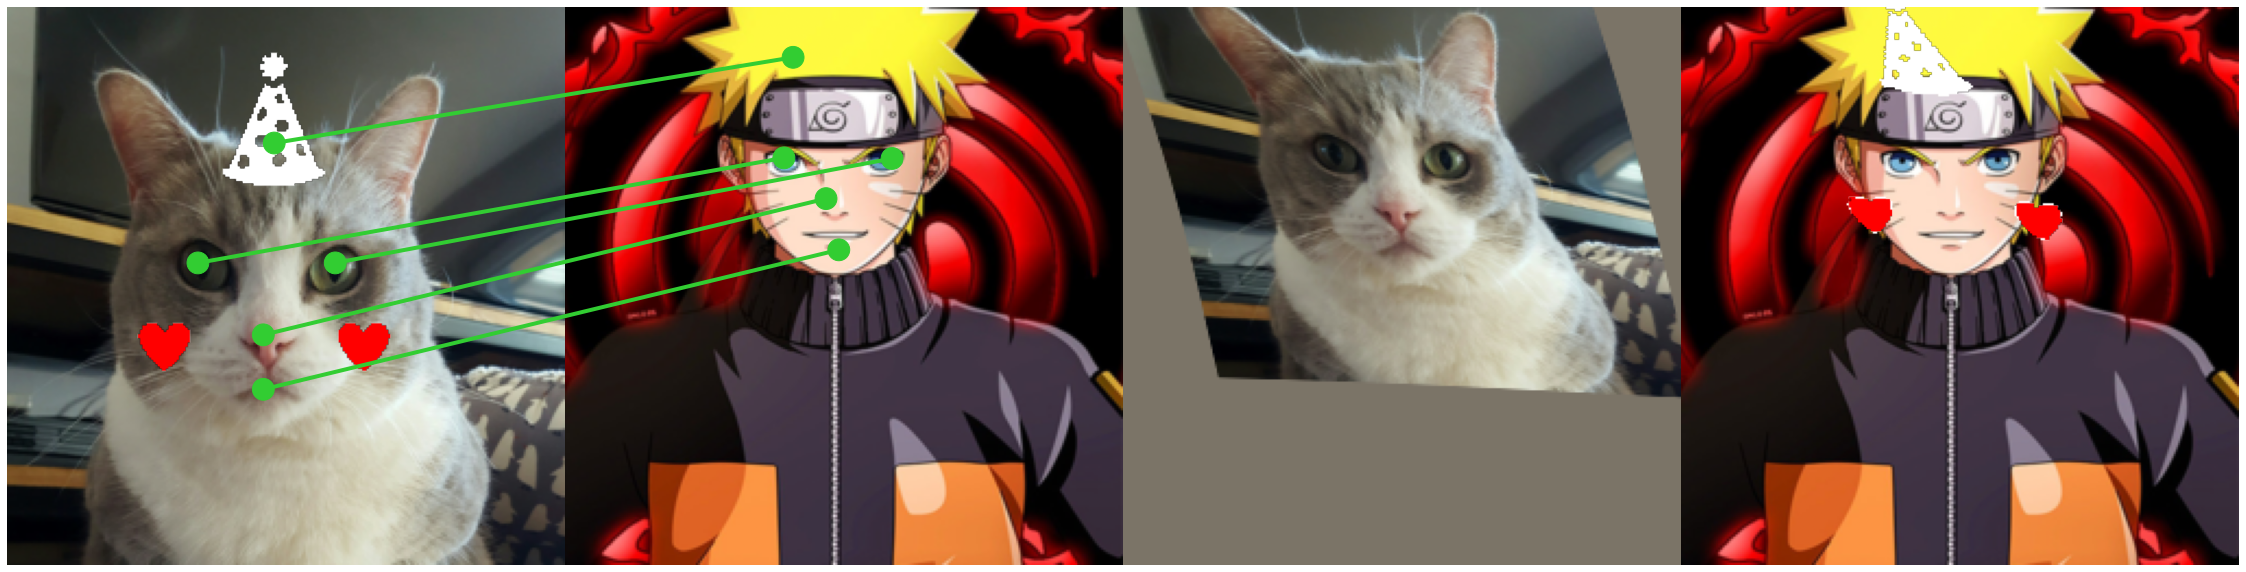

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

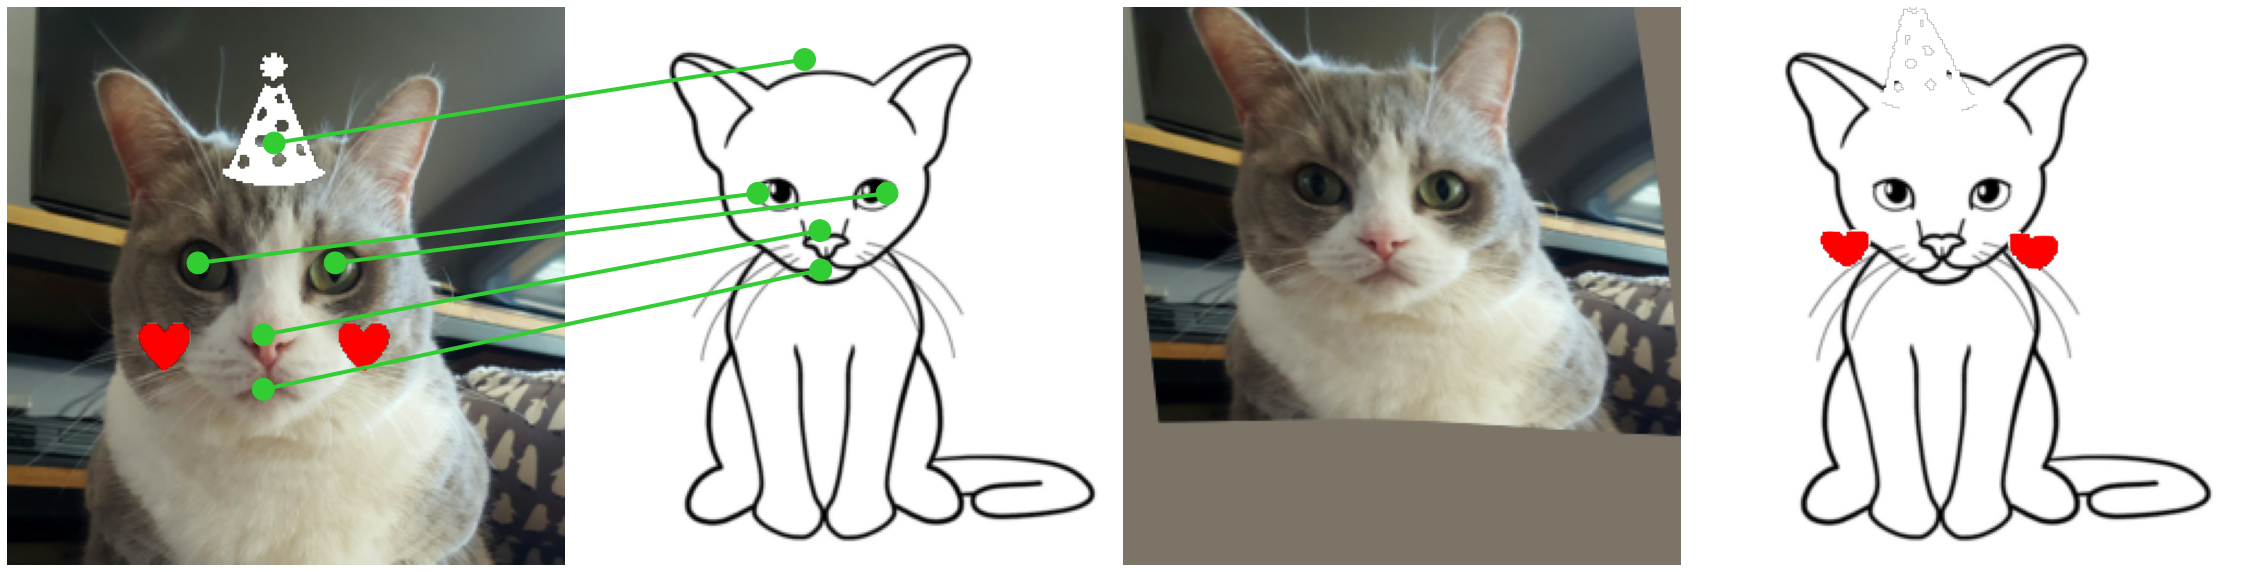

<Figure size 432x288 with 0 Axes>

In [ ]:
img_paths = [
  f'{path}/pororo.png',
  f'{path}/pororo2.png',
  f'{path}/naruto.png',
  f'{path}/drawing.png',
]

for img_path in img_paths:
  trg = load_image_tensor(img_path).to(device)
  inference(src, trg, kp_podong, img_path)

# Try your own image!

In [ ]:
from google.colab import files

uploaded = files.upload()
  
trg = load_image_tensor(tuple(uploaded.keys())[0]).to(device)
inference(src, trg, kp_podong, tuple(uploaded.keys())[0])